# LightGBM SHAP for predicting use of thrombolysis

This model use 10 features:

* stroke_team_id
* stroke_severity
* prior_disability
* age
* infarction
* onset_to_arrival_time
* precise_onset_known
* onset_during_sleep
* arrival_to_scan_time
* afib_anticoagulant

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from dataclasses import dataclass
# from lightgbm import LGBMClassifier  # moved to models module, left here for testing

/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

In [2]:
import stroke_utilities.process_data as process_data
import stroke_utilities.models as models
import stroke_utilities.scenario as scenario

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities//output/'
    model_folder = './stroke_utilities//models'
    model_text = 'lgbm_decision_'
    notebook: str = '02_'

paths = Paths()

## Load data

In [4]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

In [5]:
# Put data into the format for model
features_to_use = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [6]:
train = train[features_to_use]
test = test[features_to_use]

In [7]:
train = process_data.restrict_data_to_range(train, 2016, 2018, 'year')
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

In [8]:
X_train, y_train = process_data.split_X_and_y(train, 'thrombolysis')
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

In [9]:
# Get features
features = list(X_train)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

## Fit model

In [10]:
model = models.train_LGBMClassifier(X_train, y_train)

[LightGBM] [Info] Number of positive: 37150, number of negative: 90071
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 127221, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292012 -> initscore=-0.885634
[LightGBM] [Info] Start training from score -0.885634


In [11]:
# Get predictions
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

# Show overall accuracy
accuracy = np.mean(predicted == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.853


## Fit SHAP

In [12]:
explainer = models.create_shap_TreeExplainer(model)

In [13]:
shap_values, shap_values_extended = models.calculate_shap_values(explainer, X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [14]:
shap_values_extended[0]

.values =
array([[-0.116704  ,  0.116704  ],
       [-2.21741366,  2.21741366],
       [ 2.94414052, -2.94414052],
       [ 0.11648366, -0.11648366],
       [-1.38909061,  1.38909061],
       [-3.000617  ,  3.000617  ],
       [-0.36164034,  0.36164034],
       [-0.11242719,  0.11242719],
       [-3.8841166 ,  3.8841166 ],
       [-0.28923313,  0.28923313]])

.base_values =
array([ 7.53873459, -7.53873459])

.data =
array([90. ,  8. ,  3. , 82.5,  1. , 83. ,  1. ,  0. , 20. ,  0. ])

In [15]:
shap_values_extended.feature_names

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

## Show example waterfall plot

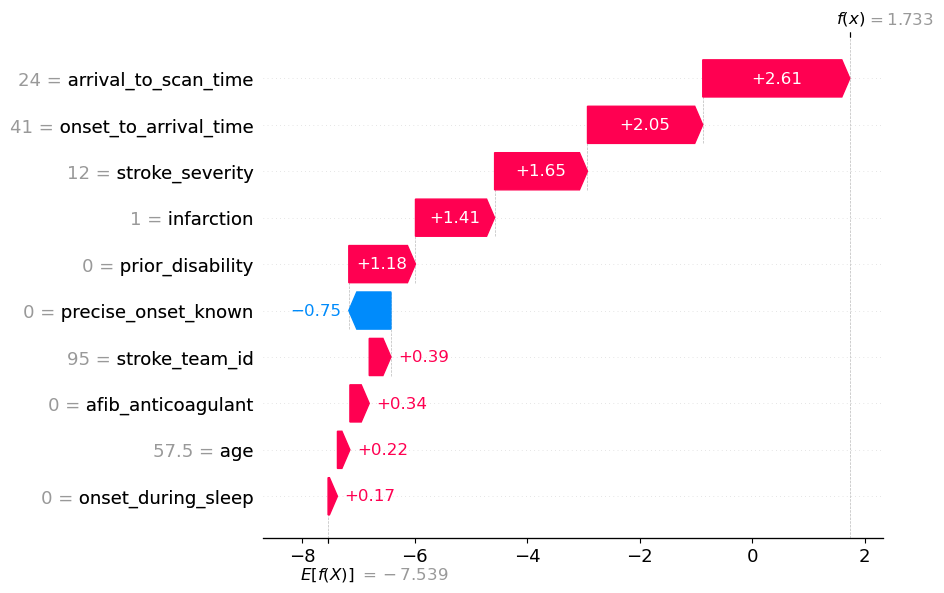

In [16]:
row = 5
class_index = 1

shap.waterfall_plot(shap.Explanation(
    values=shap_values[class_index][row],
    base_values=explainer.expected_value[class_index], data=X_test.iloc[row],
    feature_names=X_test.columns.tolist()))

In [17]:
explainer.expected_value[class_index]

-7.538734592318916

## Beeswarm

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


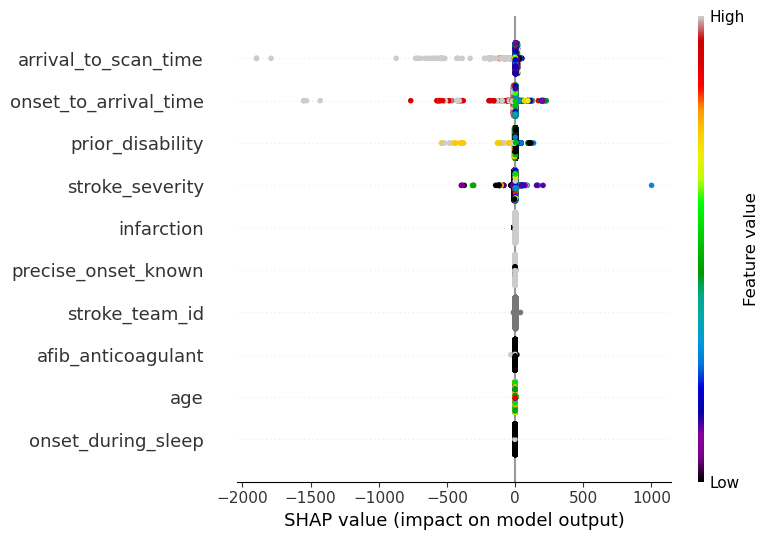

In [18]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values[1], 
                  features=X_test,
                  feature_names=features,
                  max_display=10,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

# filename = paths.output_folder + paths.notebook + paths.model_text + 'beeswarm.jpg'
# plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Get mean absolute SHAP values

In [19]:
mean_abs_shap = models.calculate_mean_absolute_shap_values(shap_values, features)

In [20]:
mean_abs_shap.round(4)

arrival_to_scan_time     8.3419
onset_to_arrival_time    7.1116
prior_disability         3.5149
stroke_severity          2.6906
infarction               2.0428
precise_onset_known      0.5233
stroke_team_id           0.4858
afib_anticoagulant       0.4755
age                      0.1715
onset_during_sleep       0.1538
dtype: float64

## Get stroke team SHAP

In [21]:
team_shap = models.calculate_shap_values_by_category(X_test, 'stroke_team_id', shap_values, features)

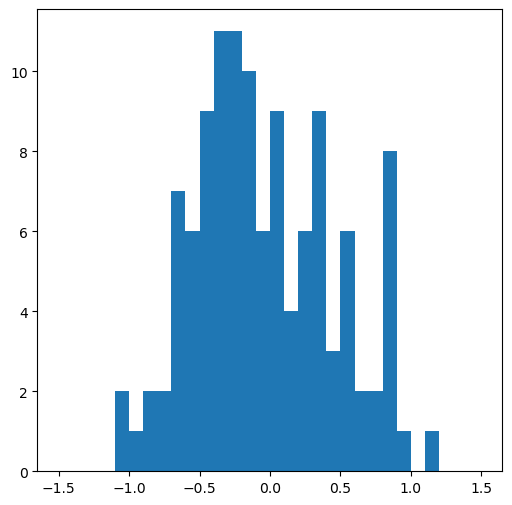

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(team_shap['SHAP_mean'], bins=np.arange(-1.5, 1.51, 0.1))

plt.show()

In [23]:
mean_shap = np.mean(team_shap['SHAP_mean'])
std_shap = np.std(team_shap['SHAP_mean'])
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP STDdev: {std_shap:0.3f}')

Mean hospital SHAP: -0.039
Mean hospital SHAP STDdev: 0.490


## Extract benchmark ranking

In [36]:
benchmark_team_shap = models.select_top_values_in_dataframe(team_shap, 'SHAP_mean', 25, ascending=False)

In [37]:
benchmark_team_id_list = benchmark_team_shap.index.values

benchmark_team_id_list

array([106,  57,  20,  14,  84,  93,   4,  53, 108, 113,  62, 107,  74,
        48,  66,  45,  63,  82,  86,  34,  94,  81,  92,  89, 104])

## Benchmark scenario

In [39]:
filename = paths.data_read_path + 'reformatted_data_thrombolysis_decision.csv'
big_data = pd.read_csv(filename)

big_data = big_data[features_to_use]

In [40]:
from stroke_utilities.scenario import predict_thrombolysis_rate_in_benchmark_scenario

In [41]:
all_teams_benchmark_thrombolysis_rates = predict_thrombolysis_rate_in_benchmark_scenario(
    big_data, 
    model,
    benchmark_team_id_list,
    team_id_column='stroke_team_id', 
    prediction_column='thrombolysis'
    )

In [42]:
all_teams_benchmark_thrombolysis_rates

,True,Base,Benchmark
1,0.147932,0.139779,0.228305
2,0.164783,0.165217,0.247391
3,0.117175,0.100321,0.195024
4,0.213944,0.231311,0.207400
5,0.081784,0.069145,0.133829
...,...,...,...
115,0.169501,0.178005,0.297619
116,0.168396,0.173982,0.218675
117,0.141473,0.135659,0.187984
118,0.148293,0.149360,0.183855


In [43]:
import matplotlib.pyplot as plt

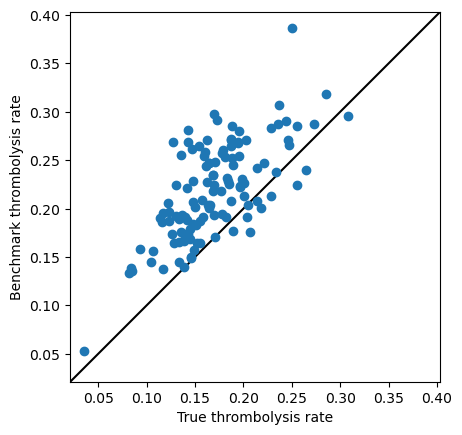

In [45]:
fig, ax = plt.subplots()
ax.scatter(
    all_teams_benchmark_thrombolysis_rates['True'],
    all_teams_benchmark_thrombolysis_rates['Benchmark']
)
ax.set_aspect('equal')
lim_min = np.min([list(ax.get_xlim()), list(ax.get_ylim())])
lim_max = np.max([list(ax.get_xlim()), list(ax.get_ylim())])
ax.set_xlim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)
ax.plot([lim_min, lim_max], [lim_min, lim_max], color='k', zorder=0)

ax.set_xlabel('True thrombolysis rate')
ax.set_ylabel('Benchmark thrombolysis rate')
plt.show()